# Importing and setting up Data Frame

In [1]:
# Downloading the CSV from Google Drive
import gdown

url = 'https://drive.google.com/uc?export=download&id=1I_4APSuj2-3lSQIygD6aQj_8ClQPmW2v'
output = 'crimedata2.csv'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1I_4APSuj2-3lSQIygD6aQj_8ClQPmW2v
To: /content/crimedata2.csv
100%|██████████| 1.56M/1.56M [00:00<00:00, 21.4MB/s]


'crimedata2.csv'

In [2]:
import pandas as pd
import numpy as np
import statistics
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [3]:
cc_df = pd.read_csv('crimedata2.csv', encoding='latin-1')

# Base line Model

### Continous Baseline Model

In [4]:
vacancy = cc_df['HousVacant']
vacancy.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2215 entries, 0 to 2214
Series name: HousVacant
Non-Null Count  Dtype
--------------  -----
2215 non-null   int64
dtypes: int64(1)
memory usage: 17.4 KB


In [5]:
vacancy_mean = vacancy.mean()
vacancy_mean

1748.368848758465

In [6]:
vacancy_meandf = pd.DataFrame([vacancy_mean] * len(vacancy), columns=['Value'])

In [7]:
mae = mean_absolute_error(vacancy, vacancy_meandf)
mse = root_mean_squared_error(vacancy, vacancy_meandf)
r2 = r2_score(vacancy, vacancy_meandf)

print('MAE:', mae)
print('Root MSE:', mse)
print('R2:', r2)

MAE: 1943.3005008942723
Root MSE: 6502.398171234124
R2: 0.0


### Categorical Baseline Model

In [8]:
vacancy_class = pd.DataFrame()
vacancy_class['Vacancy_class'] = ['High' if v > 900 else 'Low' if v < 300 else 'Medium' for v in vacancy]

# Count the occurrences of each classification
classification_counts = vacancy_class.value_counts()

print(classification_counts)

Vacancy_class
Medium           929
High             741
Low              545
Name: count, dtype: int64


In [9]:
def evaluation_predictions(prediction, actual):
  """
  Evaluates the predictions against the actual values.

  Args:
    prediction: A list or numpy array of predictions.
    actual: A pandas Series of actual values.

  Returns:
    The number of correct predictions.
  """
  correct = 0
  # Iterate through using the length of the prediction
  for i in range(len(prediction)):
    #Access the actual values using iloc to get the value at the ith position
    if prediction[i] == actual.iloc[i]:
      correct += 1

  print(f"Actual values are: {actual.value_counts()}")
  print(f"\nCorrect predictions: {correct}\n")
  return correct

In [10]:
vacancy_class_mode = pd.DataFrame()
vacancy_class_mode['Mode'] = ['Medium'] * len(vacancy_class)

cat_baseline_train = evaluation_predictions(vacancy_class_mode["Mode"], vacancy_class["Vacancy_class"])
print(f"Accuracy: {round(cat_baseline_train/len(vacancy_class)*100,2)}%")

Actual values are: Vacancy_class
Medium    929
High      741
Low       545
Name: count, dtype: int64

Correct predictions: 929

Accuracy: 41.94%


# Feature Engineering

In [11]:
# Creating all the new variables here

cc_cat = cc_df

cc_cat = cc_cat.drop(['Êcommunityname', 'state', "countyCode", "communityCode", "fold"], axis=1)

In [12]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

cc_cat.replace('?', 0, inplace=True)
imputer.fit_transform(cc_cat)


array([[1.19800e+04, 3.10000e+00, 1.37000e+00, ..., 1.64100e+01,
        4.10200e+01, 1.39459e+03],
       [2.31230e+04, 2.82000e+00, 8.00000e-01, ..., 4.25000e+00,
        1.27560e+02, 1.95595e+03],
       [2.93440e+04, 2.43000e+00, 7.40000e-01, ..., 6.08700e+01,
        2.18590e+02, 6.16751e+03],
       ...,
       [3.28240e+04, 2.46000e+00, 5.20000e-01, ..., 2.17700e+01,
        3.53830e+02, 4.65420e+03],
       [1.35470e+04, 2.89000e+00, 3.37000e+00, ..., 7.85000e+00,
        6.91170e+02, 5.34087e+03],
       [2.88980e+04, 2.61000e+00, 2.39000e+00, ..., 6.61100e+01,
        9.18890e+02, 8.83850e+03]])

In [13]:
Q1 = cc_cat['HousVacant'].quantile(0.25)
Q3 = cc_cat['HousVacant'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows where 'HousVacant' is outside the bounds
cc_cat = cc_cat[(cc_cat['HousVacant'] >= lower_bound) & (cc_cat['HousVacant'] <= upper_bound)]

cc_cat.shape

(1964, 142)

In [14]:
# PCA Analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cc_cat)

# Step 2: Apply PCA
pca = PCA()
pca.fit(cc_cat)

# Step 3: Check explained variance ratio to decide number of components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Step 4: Choose number of components (e.g., 95% variance)
num_components = next(i for i, total in enumerate(cumulative_variance) if total >= 0.95) + 1
print(f"Number of components to explain 95% variance: {num_components}")

# Step 5: Transform the data
pca = PCA(n_components=num_components)
reduced_data = pca.fit_transform(scaled_data)

# Step 6: Analyze top variables contributing to principal components
loadings = pca.components_  # Loadings of the variables
variable_contributions = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(num_components)], index=cc_cat.columns)

# Step 7: Identify top contributors for each component
top_variables = {}
for pc in variable_contributions.columns:
    top_variables[pc] = variable_contributions[pc].abs().nlargest(10).index.tolist()

print("Top variables contributing to each principal component:")
for pc, variables in top_variables.items():
    print(f"{pc}: {variables}")


Number of components to explain 95% variance: 1
Top variables contributing to each principal component:
PC1: ['PctKids2Par', 'PctFam2Par', 'pctWInvInc', 'PctYoungKids2Par', 'pctWPubAsst', 'NumUnderPov', 'PctKidsBornNeverMar', 'NumKidsBornNeverMar', 'PctPopUnderPov', 'PctTeen2Par']


In [15]:
cc_cat['OfficAssgnDrugUnits'] = pd.to_numeric(cc_cat['OfficAssgnDrugUnits'], errors='coerce')
cc_cat['PopDens'] = pd.to_numeric(cc_cat['PopDens'], errors='coerce')

cc_cat['drug_units_ratio'] = (cc_cat['OfficAssgnDrugUnits']) / (cc_cat['PopDens'])
cc_cat["vacancy_class"] = ['High' if v > 900 else 'Low' if v < 300 else 'Medium' for v in cc_cat['HousVacant']]
cc_cat["vacancy_class"].value_counts()

,count
vacancy_class,
Medium,929
Low,545
High,490


In [16]:
# Split the training and testing into a 70/30 split
from sklearn.model_selection import train_test_split

vacancy_x = cc_cat[['burglaries', 'larcenies', 'drug_units_ratio', 'NumInShelters', 'medIncome', 'RentMedian', 'pctUrban', 'MedYrHousBuilt', 'PctBornSameState']]
vacancy_y = cc_cat[['vacancy_class']]


print(vacancy_x.dtypes)

burglaries           object
larcenies            object
drug_units_ratio    float64
NumInShelters         int64
medIncome             int64
RentMedian            int64
pctUrban            float64
MedYrHousBuilt        int64
PctBornSameState    float64
dtype: object


# K-fold for all models


In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Convert to numeric
vacancy_x[['burglaries', 'larcenies']] = vacancy_x[['burglaries', 'larcenies']].apply(pd.to_numeric, errors='coerce').fillna(0)
vacancy_y_encoded = LabelEncoder().fit_transform(vacancy_y)  # Encodes 'High', 'Medium', 'Low' to 0, 1, 2

X_train, X_test, y_train, y_test = train_test_split(vacancy_x, vacancy_y, test_size=0.70, random_state=1)

models = {
    "Multiple Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs'),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', enable_categorical=False)
}
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)

scaler = StandardScaler()
vacancy_x_scaled = pd.DataFrame(scaler.fit_transform(vacancy_x), columns=vacancy_x.columns)

# Evaluate each model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} using {k}-fold cross-validation:")

    X_data = vacancy_x_scaled if model_name == "Multiple Logistic Regression" else vacancy_x
    fold_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

    for train_index, test_index in skf.split(X_data, vacancy_y_encoded):
        X_train_fold, X_test_fold = X_data.iloc[train_index], X_data.iloc[test_index]
        y_train_fold, y_test_fold = vacancy_y_encoded[train_index], vacancy_y_encoded[test_index]

        # Fit the model
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)
        y_pred_proba = model.predict_proba(X_test_fold)

        # Calculate metrics
        fold_metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
        fold_metrics['precision'].append(precision_score(y_test_fold, y_pred, average='weighted'))
        fold_metrics['recall'].append(recall_score(y_test_fold, y_pred, average='weighted'))
        fold_metrics['f1'].append(f1_score(y_test_fold, y_pred, average='weighted'))
        fold_metrics['roc_auc'].append(roc_auc_score(y_test_fold, y_pred_proba, multi_class='ovr'))

    # Calculate average metrics across all folds
    avg_accuracy = sum(fold_metrics['accuracy']) / k
    avg_precision = sum(fold_metrics['precision']) / k
    avg_recall = sum(fold_metrics['recall']) / k
    avg_f1 = sum(fold_metrics['f1']) / k
    avg_roc_auc = sum(fold_metrics['roc_auc']) / k

    print(f"  Average Accuracy: {avg_accuracy:.4f}")
    print(f"  Average Precision: {avg_precision:.4f}")
    print(f"  Average Recall: {avg_recall:.4f}")
    print(f"  Average F1-Score: {avg_f1:.4f}")
    print(f"  Average ROC-AUC: {avg_roc_auc:.4f}")

<ipython-input-17-c188ee42d558>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vacancy_x[['burglaries', 'larcenies']] = vacancy_x[['burglaries', 'larcenies']].apply(pd.to_numeric, errors='coerce').fillna(0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Evaluating Multiple Logistic Regression using 5-fold cross-validation:
  Average Accuracy: 0.6599
  Average Precision: 0.6706
  Average Recall: 0.6599
  Average F1-Score: 0.6587
  Average ROC-AUC: 0.8251

Evaluating Decision Tree using 5-fold cross-validation:
  Average Accuracy: 0.5937
  Average Precision: 0.5947
  Average Recall: 0.5937
  Average F1-Score: 0.5933
  Average ROC-AUC: 0.6875

Evaluating Random Forest using 5-fold cross-validation:
  Average Accuracy: 0.6853
  Average Precision: 0.6914
  Average Recall: 0.6853
  Average F1-Score: 0.6843
  Average ROC-AUC: 0.8461

Evaluating Naive Bayes using 5-fold cross-validation:
  Average Accuracy: 0.5922
  Average Precision: 0.6204
  Average Recall: 0.5922
  Average F1-Score: 0.5820
  Average ROC-AUC: 0.8031

Evaluating Gradient Boosting using 5-fold cross-validation:
  Average Accuracy: 0.6848
  Average Precision: 0.6907
  Average Recall: 0.6848
  Average F1-Score: 0.6841
  Average ROC-AUC: 0.8485

Evaluating XGBoost using 5-fold 

In [18]:
#print the accuracy of each fold for the models
print("\nAccuracy of each fold for each model:")
for model_name, model in models.items():
    print(f"\n{model_name}:")
    for fold, accuracy in zip(range(1, k + 1), fold_metrics['accuracy']):
        print(f"  Fold {fold}: {accuracy:.4f}")


Accuracy of each fold for each model:

Multiple Logistic Regression:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531

Decision Tree:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531

Random Forest:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531

Naive Bayes:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531

Gradient Boosting:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531

XGBoost:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531


In [19]:
#print the accuracy of each fold for the models
print("\nPrecision of each fold for each model:")
for model_name, model in models.items():
    print(f"\n{model_name}:")
    for fold, precision in zip(range(1, k + 1), fold_metrics['precision']):
        print(f"  Fold {fold}: {precision:.4f}")


Precision of each fold for each model:

Multiple Logistic Regression:
  Fold 1: 0.6703
  Fold 2: 0.6639
  Fold 3: 0.6923
  Fold 4: 0.6492
  Fold 5: 0.6550

Decision Tree:
  Fold 1: 0.6703
  Fold 2: 0.6639
  Fold 3: 0.6923
  Fold 4: 0.6492
  Fold 5: 0.6550

Random Forest:
  Fold 1: 0.6703
  Fold 2: 0.6639
  Fold 3: 0.6923
  Fold 4: 0.6492
  Fold 5: 0.6550

Naive Bayes:
  Fold 1: 0.6703
  Fold 2: 0.6639
  Fold 3: 0.6923
  Fold 4: 0.6492
  Fold 5: 0.6550

Gradient Boosting:
  Fold 1: 0.6703
  Fold 2: 0.6639
  Fold 3: 0.6923
  Fold 4: 0.6492
  Fold 5: 0.6550

XGBoost:
  Fold 1: 0.6703
  Fold 2: 0.6639
  Fold 3: 0.6923
  Fold 4: 0.6492
  Fold 5: 0.6550


In [20]:
#print the accuracy of each fold for the models
print("\nRecall of each fold for each model:")
for model_name, model in models.items():
    print(f"\n{model_name}:")
    for fold, recall in zip(range(1, k + 1), fold_metrics['recall']):
        print(f"  Fold {fold}: {recall:.4f}")


Recall of each fold for each model:

Multiple Logistic Regression:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531

Decision Tree:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531

Random Forest:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531

Naive Bayes:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531

Gradient Boosting:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531

XGBoost:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531


In [21]:
#print the accuracy of each fold for the models
print("\nF1 of each fold for each model:")
for model_name, model in models.items():
    print(f"\n{model_name}:")
    for fold, f1 in zip(range(1, k + 1), fold_metrics['f1']):
        print(f"  Fold {fold}: {f1:.4f}")




F1 of each fold for each model:

Multiple Logistic Regression:
  Fold 1: 0.6691
  Fold 2: 0.6639
  Fold 3: 0.6870
  Fold 4: 0.6455
  Fold 5: 0.6526

Decision Tree:
  Fold 1: 0.6691
  Fold 2: 0.6639
  Fold 3: 0.6870
  Fold 4: 0.6455
  Fold 5: 0.6526

Random Forest:
  Fold 1: 0.6691
  Fold 2: 0.6639
  Fold 3: 0.6870
  Fold 4: 0.6455
  Fold 5: 0.6526

Naive Bayes:
  Fold 1: 0.6691
  Fold 2: 0.6639
  Fold 3: 0.6870
  Fold 4: 0.6455
  Fold 5: 0.6526

Gradient Boosting:
  Fold 1: 0.6691
  Fold 2: 0.6639
  Fold 3: 0.6870
  Fold 4: 0.6455
  Fold 5: 0.6526

XGBoost:
  Fold 1: 0.6691
  Fold 2: 0.6639
  Fold 3: 0.6870
  Fold 4: 0.6455
  Fold 5: 0.6526


In [22]:
#print out the gradient boosting model accuracy for each kfold
print("\nAccuracy of each fold for Gradient Boosting:")
for fold, accuracy in zip(range(1, k + 1), fold_metrics['accuracy']):
    print(f"  Fold {fold}: {accuracy:.4f}")


Accuracy of each fold for Gradient Boosting:
  Fold 1: 0.6692
  Fold 2: 0.6641
  Fold 3: 0.6870
  Fold 4: 0.6463
  Fold 5: 0.6531


In [23]:
vacancy_y_encoded.shape

(1964,)

In [24]:
vacancy_y['encoded'] = vacancy_y_encoded
vacancy_y

<ipython-input-24-a645111019d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vacancy_y['encoded'] = vacancy_y_encoded


,vacancy_class,encoded
0,Low,1
1,Low,1
2,Medium,2
3,Medium,2
4,Medium,2
...,...,...
2210,Medium,2
2211,Medium,2
2212,High,0
2213,Medium,2


In [25]:
y_test.value_counts()

,count
vacancy_class,
Medium,644
Low,388
High,343


In [26]:
X_train, X_test, y_train, y_test = train_test_split(vacancy_x, vacancy_y['encoded'], test_size=0.70, random_state=1)

# Decision Trees

Sprint 4: Construct a model and compare it to the baseline model

	•	Split the dataset into training (e.g., 70%) and test (e.g., 30%) sets for model training and evaluation.
	•	Create a CART/C5.0 model and use the training dataset to predict the target variable.
	•	Create a Random Forest model and train the model using the same training dataset.
	•	Apply both models to the test dataset to predict the target variable and compare predictions from training and test datasets.
	•	Update your project report to include:
	•	Methodology for both CART/C5.0 and Random Forest models.
	•	Analyze the results and compare with the baseline model.

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
#Create a decision tree based on the CART algorithm, and the C5.0 algorithm
cart01 = DecisionTreeClassifier(max_leaf_nodes=8).fit(X_train,y_train)
c50_01 = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=8).fit(X_train,y_train)

prediction_cart01 = cart01.predict(X_test)
prediction_c50_01 = c50_01.predict(X_test)

In [29]:
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [30]:
# Accuracy
cart_accuracy = accuracy_score(y_test, prediction_cart01)
print(f"Cart Accuracy: {cart_accuracy:.2f}")

c50_accuracy = accuracy_score(y_test, prediction_c50_01)
print(f"C50 Accuracy: {c50_accuracy:.2f}")



Cart Accuracy: 0.63
C50 Accuracy: 0.63


In [31]:
accuracy_dt = accuracy_score(y_test, prediction_cart01)
precision_dt = precision_score(y_test, prediction_cart01, average='weighted')
recall_dt = recall_score(y_test, prediction_cart01, average='weighted')
f1_dt = f1_score(y_test, prediction_cart01, average='weighted')

prediction_probs_dt = cart01.predict_proba(X_test)
roc_auc_dt = roc_auc_score(y_test, prediction_probs_dt, multi_class='ovr')

print(f"Accuracy:  {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall:    {recall_dt:.4f}")
print(f"F1-Score:  {f1_dt:.4f}")
print(f"ROC-AUC:  {roc_auc_dt:.4f}")

Accuracy:  0.6320
Precision: 0.6321
Recall:    0.6320
F1-Score:  0.6310
ROC-AUC:  0.7754


In [32]:
# Confusion Matrix
cart_cm = confusion_matrix(y_test, prediction_cart01)
print("Cart Confusion Matrix:\n", cart_cm)

c50_cm = confusion_matrix(y_test, prediction_c50_01)
print("C50 Confusion Matrix:\n", c50_cm)

Cart Confusion Matrix:
 [[246  13  84]
 [  8 242 138]
 [137 126 381]]
C50 Confusion Matrix:
 [[210  14 119]
 [  3 259 126]
 [ 92 158 394]]


In [33]:
# Classification Report
cart_report = classification_report(y_test, prediction_cart01)
print("Cart Classification Report:\n", cart_report)

c50_report = classification_report(y_test, prediction_c50_01)
print("C50 Classification Report:\n", c50_report)

Cart Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.72      0.67       343
           1       0.64      0.62      0.63       388
           2       0.63      0.59      0.61       644

    accuracy                           0.63      1375
   macro avg       0.63      0.64      0.64      1375
weighted avg       0.63      0.63      0.63      1375

C50 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.61      0.65       343
           1       0.60      0.67      0.63       388
           2       0.62      0.61      0.61       644

    accuracy                           0.63      1375
   macro avg       0.64      0.63      0.63      1375
weighted avg       0.63      0.63      0.63      1375



In [34]:
# ROC AUC Score (NEEDS WORK)
y_cartprob = cart01.predict_proba(X_test)
cart_auc = roc_auc_score(y_test, y_cartprob, multi_class='ovr')
print(f"Cart ROC-AUC Score: {cart_auc:.2f}")

y_c50prob = c50_01.predict_proba(X_test)
c50_auc = roc_auc_score(y_test, y_c50prob, multi_class='ovr')
print(f"C50 ROC-AUC Score: {c50_auc:.2f}")

Cart ROC-AUC Score: 0.78
C50 ROC-AUC Score: 0.79


# Random Forest

In [35]:
#Create a decison tree using the random forest algorithm
from sklearn.ensemble import RandomForestClassifier

rf01 = RandomForestClassifier(n_estimators=500, criterion="gini").fit(X_train,y_train)

prediction_rf01 = rf01.predict(X_test)
prediction_probs_rf = rf01.predict_proba(X_test)

In [36]:
# Accuracy
rf_accuracy = accuracy_score(y_test, prediction_rf01)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

accuracy_rf = accuracy_score(y_test, prediction_rf01)
precision_rf = precision_score(y_test, prediction_rf01, average='weighted')
recall_rf = recall_score(y_test, prediction_rf01, average='weighted')
f1_rf = f1_score(y_test, prediction_rf01, average='weighted')
roc_auc_rf = roc_auc_score(y_test, prediction_probs_rf, multi_class='ovr')

print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")
print(f"ROC-AUC:  {roc_auc_rf:.4f}")

Random Forest Accuracy: 0.67
Accuracy:  0.6676
Precision: 0.6699
Recall:    0.6676
F1-Score:  0.6677
ROC-AUC:  0.8301


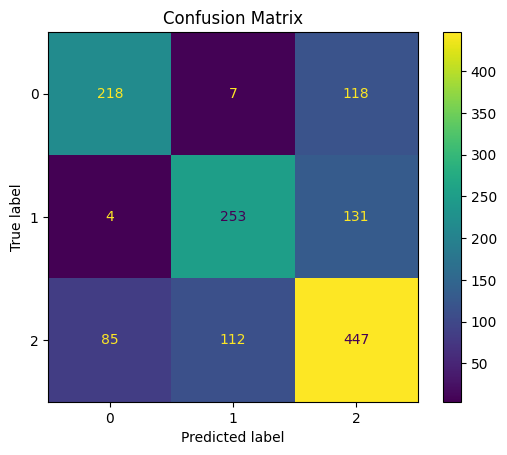

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf01, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

In [38]:
y_train.value_counts()

,count
encoded,
2,285
1,157
0,147


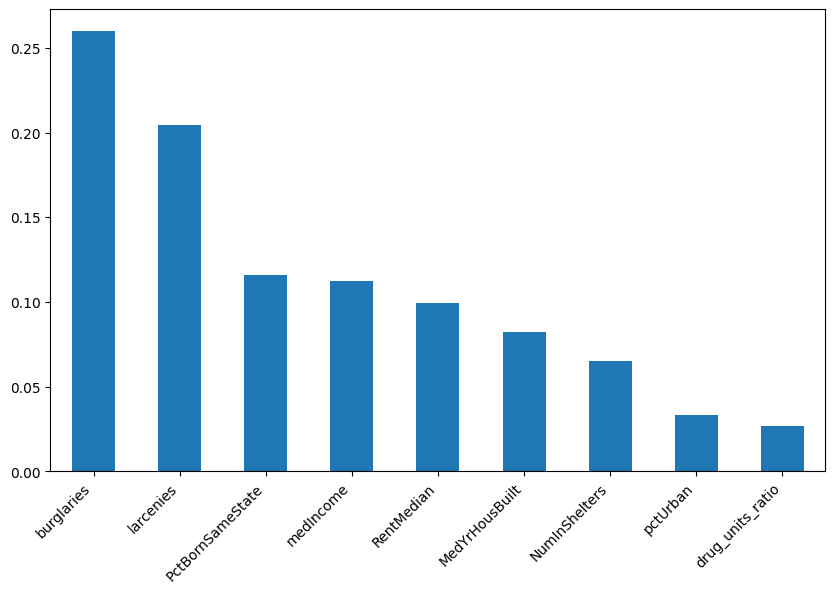

In [39]:
import pandas as pd

# Extract feature importances and visualize
feature_importances = pd.Series(rf01.feature_importances_, index=X_test.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.xticks(rotation=45, ha='right')
plt.show()


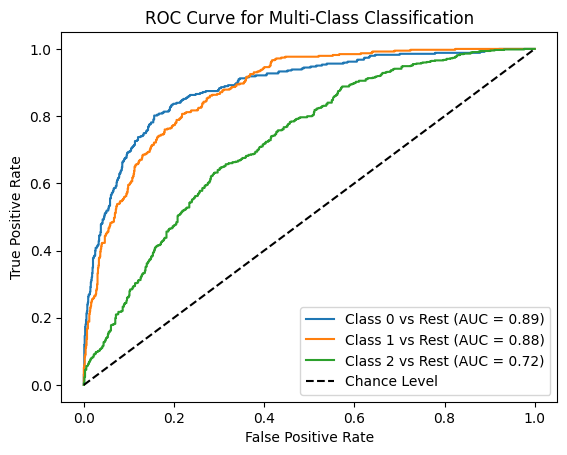

In [40]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc # Import roc_curve and auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# Binarize the target labels for multi-class ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=rf01.classes_)
n_classes = y_test_bin.shape[1]

# Create a OneVsRestClassifier to handle multi-class ROC AUC
classifier = OneVsRestClassifier(rf01)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Iterate through each class and plot a one-vs-rest ROC curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr) # Now auc should be defined as well

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'Class {i} vs Rest (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

In [41]:
# Confusion Matrix
rf_cm = confusion_matrix(y_test, prediction_rf01)
print("Random Forest Confusion Matrix:\n", rf_cm)

Random Forest Confusion Matrix:
 [[218   7 118]
 [  4 253 131]
 [ 85 112 447]]


In [42]:
# Classification Report
rf_report = classification_report(y_test, prediction_rf01)
print("Random Forest Classification Report:\n", rf_report)


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.64      0.67       343
           1       0.68      0.65      0.67       388
           2       0.64      0.69      0.67       644

    accuracy                           0.67      1375
   macro avg       0.68      0.66      0.67      1375
weighted avg       0.67      0.67      0.67      1375



In [43]:
comparison_df = pd.DataFrame({
    'Actual Train': y_test,
    'CART Train': prediction_cart01,
    'C5.0 Train': prediction_c50_01,
    'RandomForest Train': prediction_rf01,
})

# Display comparison table
comparison_df.head()

,Actual Train,CART Train,C5.0 Train,RandomForest Train
137,2,2,2,2
696,0,0,0,2
1980,1,2,2,2
1840,1,2,1,2
2168,2,2,2,2


# Gradient Boosting

In [44]:
# Gradient Boosting Model (Independent)
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [45]:
# Get predicted probabilities instead of class labels
y_pred_prob_gb = gb_model.predict_proba(X_test)

# Get the predicted classes
y_pred_gb = gb_model.predict(X_test)

# Evaluate the Gradient Boosting model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
recall_gb = recall_score(y_test, y_pred_gb, average='weighted')
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')
roc_auc_gb = roc_auc_score(y_test, y_pred_prob_gb, multi_class='ovr')

print(f"Accuracy:  {accuracy_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall:    {recall_gb:.4f}")
print(f"F1-Score:  {f1_gb:.4f}")
print(f"ROC-AUC:  {roc_auc_gb:.4f}")

print(f"\nGradient Boosting (Independent) Accuracy: {accuracy_gb:.4f}")
print(classification_report(y_test, y_pred_gb))

Accuracy:  0.6509
Precision: 0.6518
Recall:    0.6509
F1-Score:  0.6508
ROC-AUC:  0.8208

Gradient Boosting (Independent) Accuracy: 0.6509
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       343
           1       0.65      0.61      0.63       388
           2       0.63      0.67      0.65       644

    accuracy                           0.65      1375
   macro avg       0.66      0.65      0.65      1375
weighted avg       0.65      0.65      0.65      1375



# Naive Bayes


In [46]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.5883636363636363


In [47]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)


y_pred_nb = nb_model.predict(X_test)
y_prob_nb = nb_model.predict_proba(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
roc_auc_nb = roc_auc_score(y_test, y_prob_nb, multi_class='ovr')

# Print results
print("Naive Bayes Evaluation Metrics:")
print(f"Accuracy:  {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall:    {recall_nb:.4f}")
print(f"F1-Score:  {f1_nb:.4f}")
print(f"ROC-AUC:   {roc_auc_nb:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nb))



Naive Bayes Evaluation Metrics:
Accuracy:  0.5884
Precision: 0.6151
Recall:    0.5884
F1-Score:  0.5780
ROC-AUC:   0.8006

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.54      0.62       343
           1       0.52      0.88      0.65       388
           2       0.62      0.44      0.51       644

    accuracy                           0.59      1375
   macro avg       0.62      0.62      0.59      1375
weighted avg       0.62      0.59      0.58      1375



# Multiple Logistic Regression (for binary classification tasks)


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder


# Label Encode the target variable
label_encoder = LabelEncoder()
cc_cat["vacancy_class_encoded"] = label_encoder.fit_transform(cc_cat["vacancy_class"])

# Define features and encoded target
X = cc_cat[['burglaries', 'larcenies', 'NumInShelters', 'medIncome', 'RentMedian']]  # Features
y = cc_cat['vacancy_class_encoded']  # Encoded multi-class target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize and train the Logistic Regression model for multi-class classification
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logit = logistic_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_logit))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logit))
print("Classification Report:\n", classification_report(y_test, y_pred_logit, target_names=label_encoder.classes_))


Accuracy: 0.6271186440677966
Confusion Matrix:
 [[ 88   4  58]
 [  1  84  80]
 [ 36  41 198]]
Classification Report:
               precision    recall  f1-score   support

        High       0.70      0.59      0.64       150
         Low       0.65      0.51      0.57       165
      Medium       0.59      0.72      0.65       275

    accuracy                           0.63       590
   macro avg       0.65      0.61      0.62       590
weighted avg       0.64      0.63      0.62       590



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
accuracy_logit = accuracy_score(y_test, y_pred_logit)
precision_logit = precision_score(y_test, y_pred_logit, average='weighted')
recall_logit = recall_score(y_test, y_pred_logit, average='weighted')
f1_logit = f1_score(y_test, y_pred_logit, average='weighted')

y_prob_logit = logistic_model.predict_proba(X_test)
roc_auc_logit = roc_auc_score(y_test, y_prob_logit, multi_class='ovr')

print(f"Accuracy:  {accuracy_logit:.4f}")
print(f"Precision: {precision_logit:.4f}")
print(f"Recall:    {recall_logit:.4f}")
print(f"F1-Score:  {f1_logit:.4f}")
print(f"ROC-AUC:   {roc_auc_nb:.4f}")

Accuracy:  0.6271
Precision: 0.6358
Recall:    0.6271
F1-Score:  0.6246
ROC-AUC:   0.8006


# Multiple Linear Regrssion Model

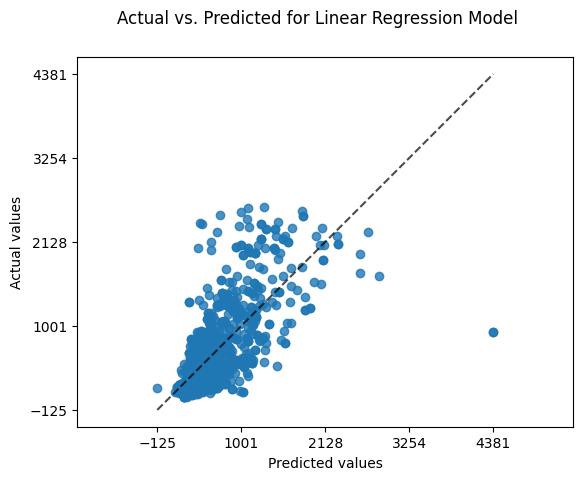

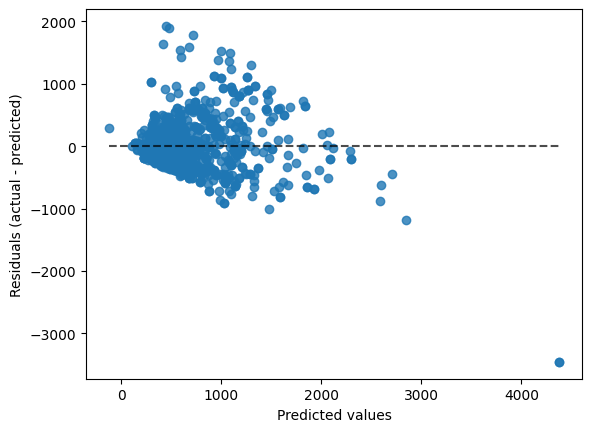

Root Mean Squared Error (MSE): 398.13738007940776
R-squared (R²): 0.483801135101147


In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, PredictionErrorDisplay

# Initialize the linear regression model
linear_model = LinearRegression()

mlr_x = cc_cat[['burglaries', 'larcenies', 'drug_units_ratio', 'NumInShelters', 'medIncome', 'RentMedian', 'pctUrban', 'MedYrHousBuilt', 'PctBornSameState']]
mlr_y = cc_cat['HousVacant']

X_train, X_test, y_train, y_test = train_test_split(mlr_x, mlr_y, test_size=0.70, random_state=1)

# Train the model using the training dataset (X_train and y_train)
linear_model.fit(X_train, y_train)  # y_train should be continuous (e.g., HousVacant)

y_pred_linear = linear_model.predict(X_test)
mse = root_mean_squared_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

display = PredictionErrorDisplay.from_predictions(y_test, y_pred_linear, kind="actual_vs_predicted")
display.figure_.suptitle("Actual vs. Predicted for Linear Regression Model")
display.plot()
plt.show()

print(f"Root Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# K means Clustering

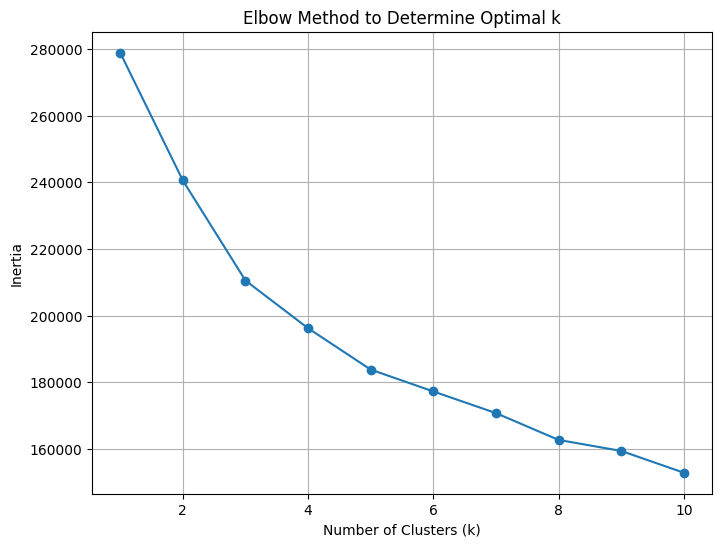

Cluster
0     726.791343
1     484.870349
2    1416.232955
Name: HousVacant, dtype: float64
Value Counts of Each Cluster:
Cluster
0    901
1    887
2    176
Name: count, dtype: int64


In [51]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

cc_cat2 = cc_cat.copy()

inertia = []
k_range = range(1, 11)  # Testing 1 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.grid()
plt.show()

# Step 5: Choose the optimal k (e.g., from the elbow curve)
optimal_k = 3  # Replace with your chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cc_cat2['Cluster'] = kmeans.fit_predict(scaled_data)

# Step 6: Analyze clusters
print(cc_cat2.groupby('Cluster')['HousVacant'].mean())  # Example summary by cluster

cluster_counts = cc_cat2['Cluster'].value_counts()

# Print the cluster counts
print("Value Counts of Each Cluster:")
print(cluster_counts)
